# About

This notebook will be the main evaluations of the models.

Credits to Garg et. al for the code, which we modified. The original source can be found [here](https://github.com/dtsip/in-context-learning)

In [44]:
from collections import OrderedDict, defaultdict
import re
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [42]:
# Displaying the directories
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,mamba,kernel_regression,mamba_kernel_regression,,-1,-1,5,12,NaN,mamba_kernel_regression
1,nanogpt,kernel_regression,nanogpt_kernel_regression,,-1,-1,5,12,8.0,nanogpt_kernel_regression


In [43]:
# Defining some hyperparameters for generating figures
task = "kernel_regression"
run_id_nanogpt = "nanogpt"
run_path_nanogpt = os.path.join(run_dir, task, run_id_nanogpt)

run_id_mamba = "mamba"
run_path_mamba = os.path.join(run_dir, task, run_id_mamba)

# Running Metrics

Recomputing metrics: getting nanoGPT and Mamba to run on the same dataset to get an equal comparison and also adding the distribution shifts

In [ ]:
# RUN THIS ONLY IF YOU NEED TO RECOMPUTE THE METRICS
# get_run_metrics([run_path_nanogpt, run_path_mamba])

# Figure 1: Context Window Size vs. Squared Error

In [37]:
def valid_row(r):
    return r.task == task and r.run_id == run_id_nanogpt

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path_nanogpt, only_conf=True)
n_dims = conf.model.n_dims

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


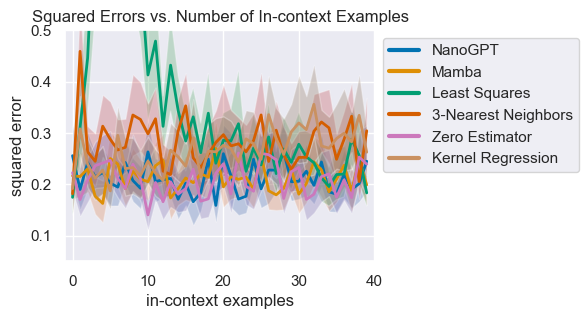

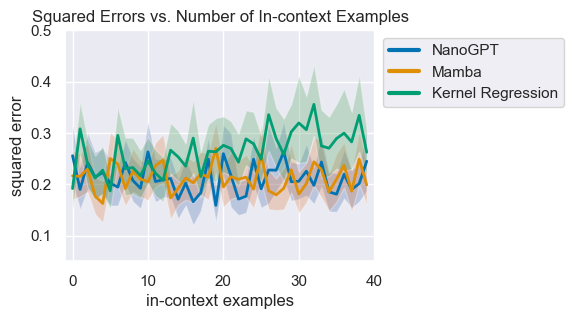

In [ ]:
models = relevant_model_names[task]
models = [name for name in models if name not in ["Averaging"]]
basic_plot(metrics["standard"], models=models, ylim=(0.05, 0.5))
plt.title("Squared Errors vs. Number of In-context Examples")
plt.show()

models = relevant_model_names[task]
models = [name for name in models if name in ["Kernel Regression", "NanoGPT", "Mamba"]]
basic_plot(metrics["standard"], models=models, ylim=(0.05, 0.5))
plt.title("Squared Errors vs. Number of In-context Examples")
plt.show()

# Figure 2: Context Window Size vs. Distribution Shifts

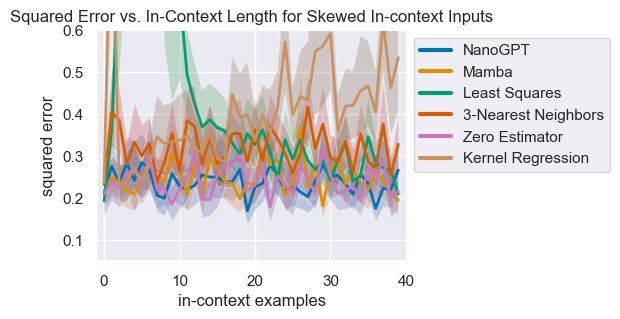

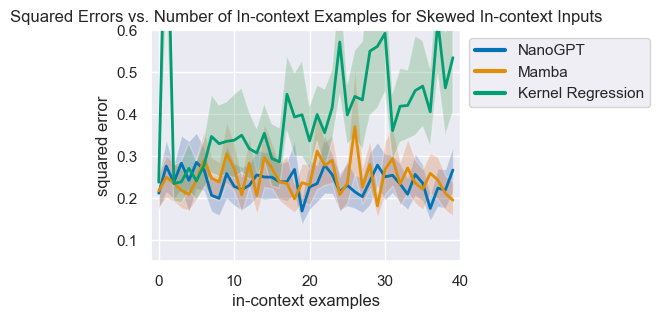

In [59]:
models = relevant_model_names[task]
models = [name for name in models if name not in ["Averaging"]]
basic_plot(metrics["skewed"], models=models, ylim=(0.05, 0.6))
plt.title("Squared Error vs. In-Context Length for Skewed In-context Inputs")
plt.show()

models = relevant_model_names[task]
models = [name for name in models if name in ["Kernel Regression", "NanoGPT", "Mamba"]]
basic_plot(metrics["skewed"], models=models, ylim=(0.05, 0.6))
plt.title("Squared Errors vs. Number of In-context Examples for Skewed In-context Inputs")
plt.show()

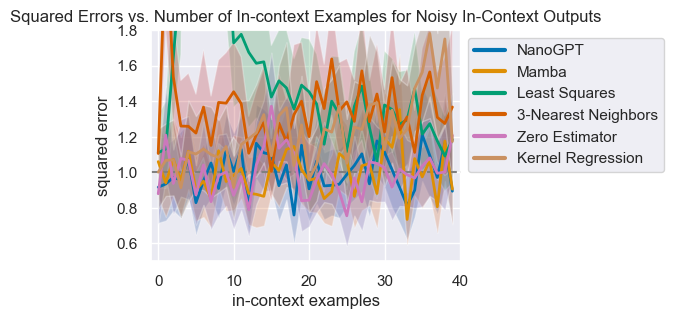

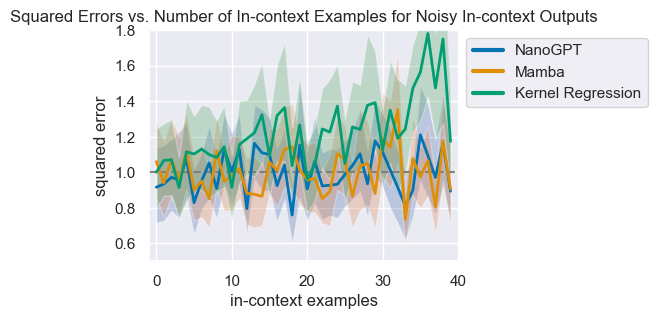

In [60]:
models = relevant_model_names[task]
models = [name for name in models if name not in ["Averaging"]]
basic_plot(metrics["noisyKR"], models=models, ylim=(0.5, 1.8))
plt.title("Squared Errors vs. Number of In-context Examples for Noisy In-Context Outputs")
plt.show()

models = relevant_model_names[task]
models = [name for name in models if name in ["Kernel Regression", "NanoGPT", "Mamba"]]
basic_plot(metrics["noisyKR"], models=models, ylim=(0.5, 1.8))
plt.title("Squared Errors vs. Number of In-context Examples for Noisy In-context Outputs")
plt.show()

# Figure 3: ICL Regression Score

In [61]:
def valid_row_nanogpt(r):
    return r.task == task and r.run_id == run_id_nanogpt

def valid_row_mamba(r):
    return r.task == task and r.run_id == run_id_mamba

In [147]:
def compute_icl_regression_score(model_name, test_type="standard", base="Zero Estimator"):
    if model_name in ["NanoGPT", "Mamba"]:
        metrics = collect_results(run_dir, df, valid_row=valid_row_nanogpt)
    # elif model_name == "Mamba":
    #     metrics = collect_results(run_dir, df, valid_row=valid_row_mamba)
    else:
        raise Exception("invalid model name")

    # print(metrics[test_type].keys())

    baseline_names = ['3-Nearest Neighbors', 'Averaging', 'Least Squares', 'Kernel Regression']
    if base in metrics[test_type].keys():
        zero_losses = np.array(metrics[test_type][base]["mean"])
    elif base == "zero":
        zero_losses = np.zeros_like(metrics[test_type]["Zero Estimator"]["mean"])
    model_losses = np.array(metrics[test_type][model_name]["mean"])
    
    icl_scores = {}
    numerator = np.sum(model_losses - zero_losses)

    for baseline_name in baseline_names:
        baseline_losses = metrics[test_type][baseline_name]["mean"]
        denominator = np.sum(baseline_losses - zero_losses)

        if denominator > 0:
            # Baseline performs worse than zero estimator, meaning the bigger the denominator, the higher the score should be
            # Invert the fraction!
            score = denominator / np.abs(numerator) if denominator != 0 else float('nan')
        else:
            score = numerator / denominator if denominator != 0 else float("nan")
        icl_scores[baseline_name] = (score, numerator, denominator)

    return icl_scores

In [109]:
nanogpt_icl_scores = compute_icl_regression_score("NanoGPT")

for baseline_name, icl_score in nanogpt_icl_scores.items():
    print(baseline_name, icl_score)

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]

3-Nearest Neighbors (25.5177894403442, 0.11513305902481072, 2.9379411578178405)
Averaging (43.94427452881073, 0.11513305902481072, 5.0594387531280525)
Least Squares (10105.759746599248, 0.11513305902481072, 1163.5070333957674)
Kernel Regression (19.424645174637035, 0.11513305902481072, 2.2364188194274903)


In [110]:
mamba_icl_scores = compute_icl_regression_score("Mamba")

for baseline_name, icl_score in mamba_icl_scores.items():
    print(baseline_name, icl_score)

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 1494.05it/s]

3-Nearest Neighbors (22.57389865025963, 0.1301477074623107, 2.9379411578178405)
Averaging (38.87458989312746, 0.1301477074623107, 5.0594387531280525)
Least Squares (8939.896492089236, 0.1301477074623107, 1163.5070333957674)
Kernel Regression (17.18369737765171, 0.1301477074623107, 2.2364188194274903)


In [111]:
# Sort models by score
def plot_icl_regression_score(icl_scores, model_name):
    sorted_scores = dict(sorted(icl_scores.items(), key=lambda x: -x[1]))

    plt.figure(figsize=(8, 4))
    plt.bar(sorted_scores.keys(), sorted_scores.values(), color="skyblue")
    plt.axhline(1.0, color="gray", linestyle="--", label="Baseline (score = 1)")
    plt.axhline(0.0, color="red", linestyle="--", label="Zero predictor")

    plt.ylabel("ICL Regression Score")
    plt.title(f"In-Context Learning Regression Scores for {model_name}")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

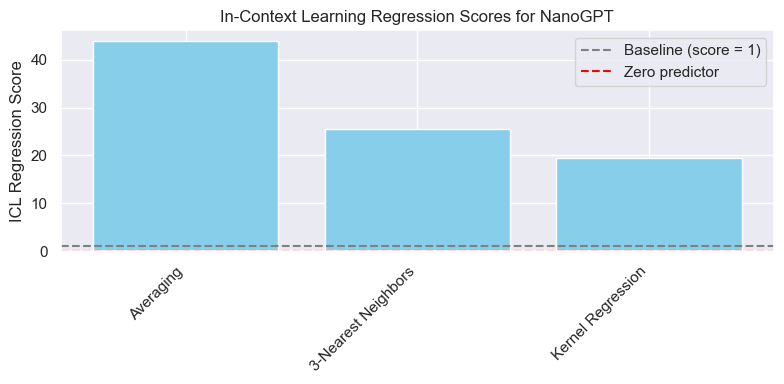

In [118]:
plot_icl_regression_score({k: v[0] for k, v in nanogpt_icl_scores.items() if k not in ["Least Squares"]}, "NanoGPT")

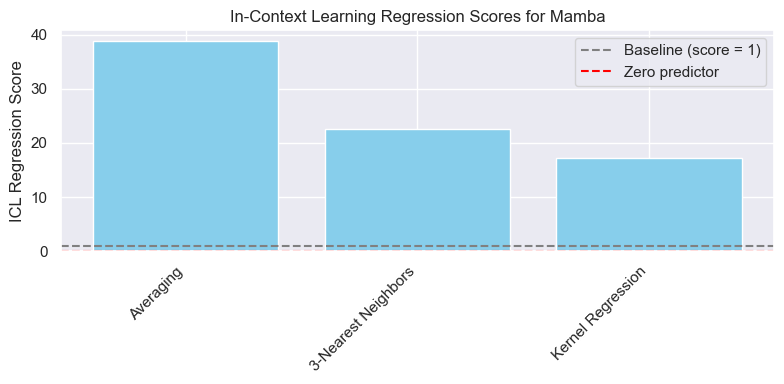

In [119]:
plot_icl_regression_score({k: v[0] for k, v in mamba_icl_scores.items() if k not in ["Least Squares"]}, "Mamba")

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 2991.66it/s]

   3-Nearest Neighbors  Averaging  Least Squares  Kernel Regression
0            24.949658  97.618517    1495.987444          52.559297


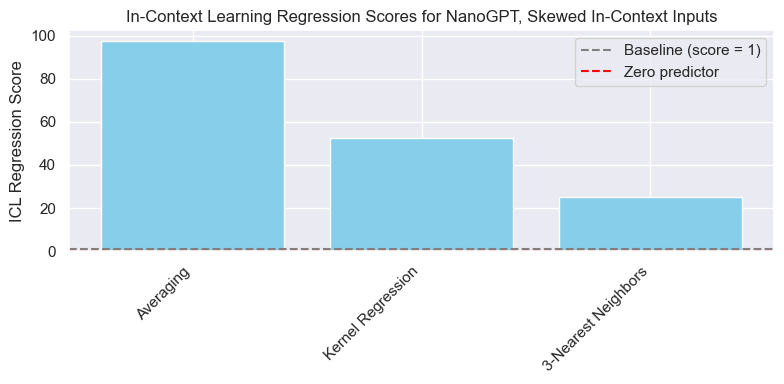

In [ ]:
nanogpt_icl_scores_skew = compute_icl_regression_score("NanoGPT", "skewed")
print(pd.DataFrame({k: v[0] for k, v in nanogpt_icl_scores_skew.items()}, index=range(1)))
plot_icl_regression_score({k: v[0] for k, v in nanogpt_icl_scores_skew.items() if k not in ["Least Squares"]}, "NanoGPT, Skewed In-Context Inputs")

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]

   3-Nearest Neighbors  Averaging  Least Squares  Kernel Regression
0            10.381596  40.619237     622.483004          21.870016


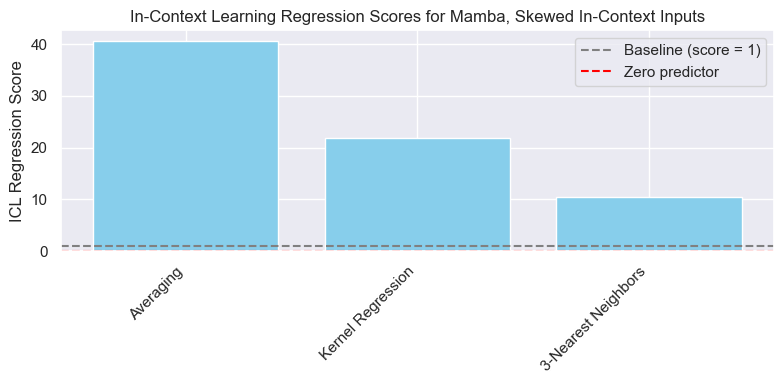

In [120]:
mamba_icl_scores_skew = compute_icl_regression_score("Mamba", "skewed")
print(pd.DataFrame({k: v[0] for k, v in mamba_icl_scores_skew.items()}, index=range(1)))
plot_icl_regression_score({k: v[0] for k, v in mamba_icl_scores_skew.items() if k not in ["Least Squares"]}, "Mamba, Skewed In-Context Inputs")

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]

   3-Nearest Neighbors    Averaging  Least Squares  Kernel Regression
0           863.777635  1091.965957  164399.954309         548.891985


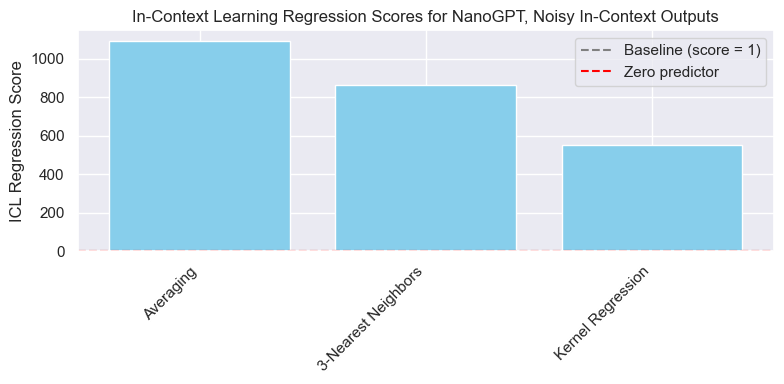

In [116]:
nanogpt_icl_scores_noisykr = compute_icl_regression_score("NanoGPT", "noisyKR")
print(pd.DataFrame({k: v[0] for k, v in nanogpt_icl_scores_noisykr.items()}, index=range(1)))
plot_icl_regression_score({k: v[0] for k, v in nanogpt_icl_scores_noisykr.items() if k not in ["Least Squares"]}, "NanoGPT, Noisy In-Context Outputs")

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 3085.56it/s]

   3-Nearest Neighbors     Averaging  Least Squares  Kernel Regression
0         36454.865327  46085.323661   6.938335e+06       23165.433532


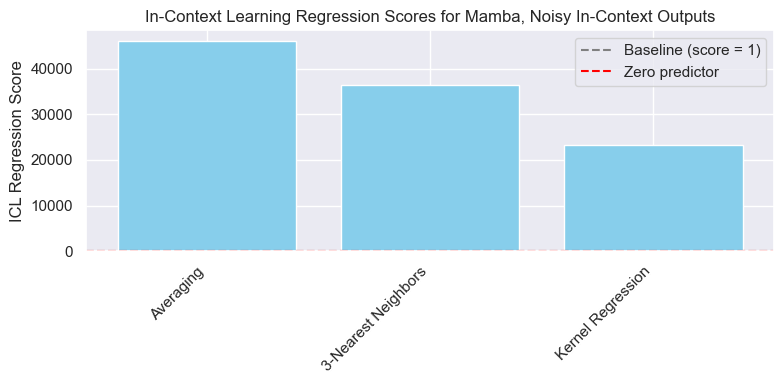

In [132]:
mamba_icl_scores_noisykr = compute_icl_regression_score("Mamba", "noisyKR")
print(pd.DataFrame({k: v[0] for k, v in mamba_icl_scores_noisykr.items()}, index=range(1)))
plot_icl_regression_score({k: v[0] for k, v in mamba_icl_scores_noisykr.items() if k not in ["Least Squares"]}, "Mamba, Noisy In-Context Outputs")

## Full Dataframe and Plots

In [135]:
# Creating DataFrame Index
model_names = ["NanoGPT", "Mamba"]
data_names = ["Standard", "Skewed", "NoisyKR"]

index = []
for name in data_names:
    for m in model_names:
        index.append(m + ", " + name)

# Creating Dataframe
icl_score_full = {}
results = [nanogpt_icl_scores, mamba_icl_scores, nanogpt_icl_scores_skew, mamba_icl_scores_skew, nanogpt_icl_scores_noisykr, mamba_icl_scores_noisykr]
for d in results:
    for k, v in d.items():
        if icl_score_full.get(k):
            icl_score_full[k].append(v[0])
        else:
            icl_score_full[k] = [v[0]] # Extracting data: baseline_name : (icl_score, numerator, denominator)

icl_score_full = pd.DataFrame(icl_score_full, index=index)
icl_score_full

,3-Nearest Neighbors,Averaging,Least Squares,Kernel Regression
"NanoGPT, Standard",25.517789,43.944275,1.010576e+04,19.424645
"Mamba, Standard",22.573899,38.874590,8.939896e+03,17.183697
"NanoGPT, Skewed",24.949658,97.618517,1.495987e+03,52.559297
"Mamba, Skewed",10.381596,40.619237,6.224830e+02,21.870016
"NanoGPT, NoisyKR",863.777635,1091.965957,1.644000e+05,548.891985
"Mamba, NoisyKR",36454.865327,46085.323661,6.938335e+06,23165.433532


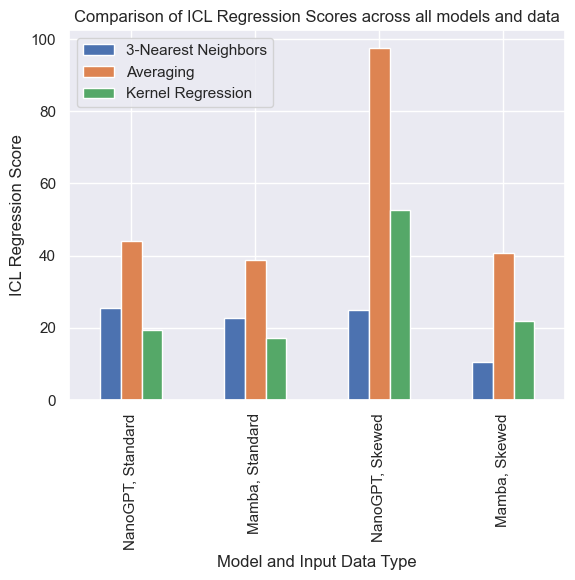

In [137]:
# Plotting
icl_score_full[[col for col in icl_score_full.columns if col not in ["Least Squares"]]].iloc[:4, :].plot.bar()
plt.xlabel("Model and Input Data Type")
plt.ylabel("ICL Regression Score")
plt.title("Comparison of ICL Regression Scores across all models and data")
plt.show()

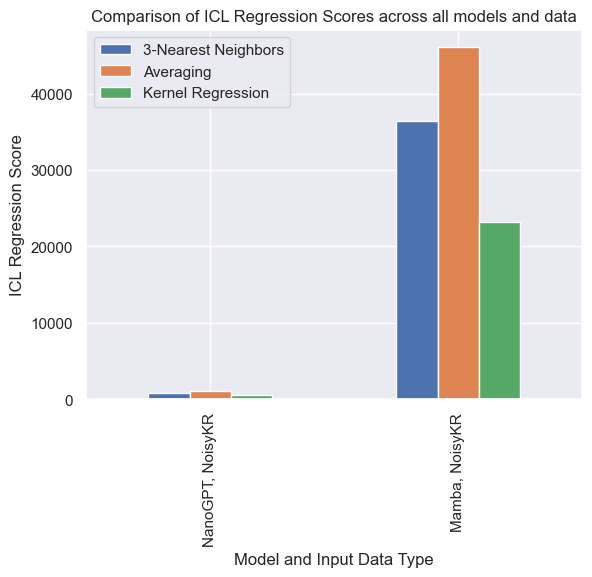

In [138]:
# Plotting - Noisy KR has very high scores
icl_score_full[[col for col in icl_score_full.columns if col not in ["Least Squares"]]].iloc[4:, :].plot.bar()
plt.xlabel("Model and Input Data Type")
plt.ylabel("ICL Regression Score")
plt.title("Comparison of ICL Regression Scores across all models and data")
plt.show()

## Testing out Different ICL Regression Implementations

In [154]:
# comparing to squared errors of zero
icl_score_full_zeros = {}

for d in data_names:
    for m in model_names:
        # Calculate the ICL regression scores
        test_type = d.lower()
        if test_type == "noisykr": test_type = "noisyKR"
        scores = compute_icl_regression_score(m, test_type=test_type, base="zero")
        # Add to dictionary
        for k, v in scores.items():
            if icl_score_full_zeros.get(k):
                icl_score_full_zeros[k].append(v[0])
                icl_score_full_zeros[k + "_numerator"].append([v[1]])
                icl_score_full_zeros[k + "_denominator"].append([v[2]])
            else:
                icl_score_full_zeros[k] = [v[0]]
                icl_score_full_zeros[k + "_numerator"] = [v[1]]
                icl_score_full_zeros[k + "_denominator"] = [v[2]]
icl_score_full_zeros = pd.DataFrame(icl_score_full_zeros, index=index)
icl_score_full_zeros

nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 2999.50it/s]


nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 1936.13it/s]

nanogpt_kernel_regression

 nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<00:00, 3020.38it/s]


nanogpt_kernel_regression nanogpt


100%|██████████| 3/3 [00:00<?, ?it/s]


,3-Nearest Neighbors,3-Nearest Neighbors_numerator,3-Nearest Neighbors_denominator,Averaging,Averaging_numerator,Averaging_denominator,Least Squares,Least Squares_numerator,Least Squares_denominator,Kernel Regression,Kernel Regression_numerator,Kernel Regression_denominator
"NanoGPT, Standard",1.333780,8.457088,11.279896,1.584635,8.457088,13.401394,138.564127,8.457088,1171.848988,1.250829,8.457088,10.578374
"Mamba, Standard",1.331416,[8.472102475166322],[11.27989592552185],1.581826,[8.472102475166322],[13.401393520832062],138.318557,[8.472102475166322],[1171.8489881634712],1.248613,[8.472102475166322],[10.578373587131502]
"NanoGPT, Skewed",1.340245,[9.527732443809509],[12.769491386413574],2.293058,[9.527732443809509],[21.84764301776886],20.628074,[9.527732443809509],[196.5387721300125],1.702254,[9.527732443809509],[16.21862344741821]
"Mamba, Skewed",1.282994,[9.952884221076966],[12.769491386413574],2.195107,[9.952884221076966],[21.84764301776886],19.746916,[9.952884221076966],[196.5387721300125],1.629540,[9.952884221076966],[16.21862344741821]
"NanoGPT, NoisyKR",1.350950,[39.988349485397336],[54.022256755828856],1.443555,[39.988349485397336],[57.72537488937378],67.718306,[39.988349485397336],[2707.943270397186],1.223161,[39.988349485397336],[48.912184715270996]
"Mamba, NoisyKR",1.350415,[40.00419330596924],[54.022256755828856],1.442983,[40.00419330596924],[57.72537488937378],67.691485,[40.00419330596924],[2707.943270397186],1.222676,[40.00419330596924],[48.912184715270996]


In [160]:
# Display Table without Numerator/Denominator
icl_score_full_zeros[[col for col in icl_score_full_zeros.columns if ("numerator" not in col) and ("denominator" not in col)]]

,3-Nearest Neighbors,Averaging,Least Squares,Kernel Regression
"NanoGPT, Standard",1.333780,1.584635,138.564127,1.250829
"Mamba, Standard",1.331416,1.581826,138.318557,1.248613
"NanoGPT, Skewed",1.340245,2.293058,20.628074,1.702254
"Mamba, Skewed",1.282994,2.195107,19.746916,1.629540
"NanoGPT, NoisyKR",1.350950,1.443555,67.718306,1.223161
"Mamba, NoisyKR",1.350415,1.442983,67.691485,1.222676


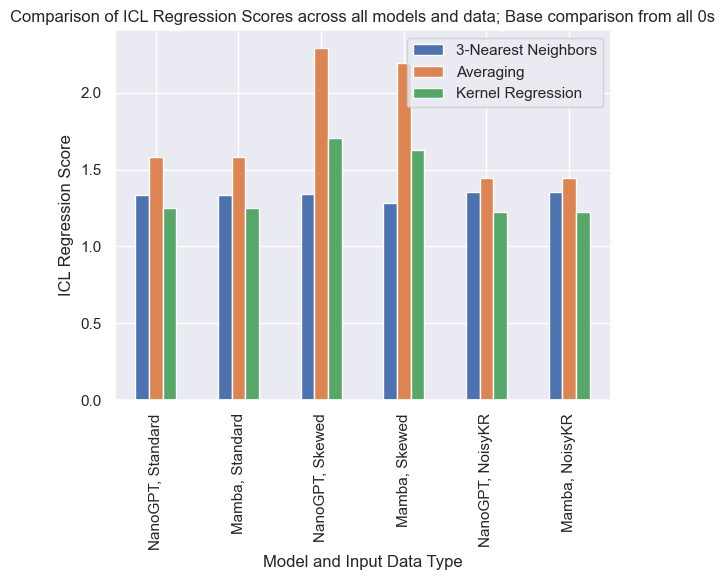

In [159]:
# Plotting 
icl_score_full_zeros[[col for col in icl_score_full_zeros.columns if ("Least Squares" not in col) and  ("numerator" not in col) and ("denominator" not in col)]].plot.bar()
plt.xlabel("Model and Input Data Type")
plt.ylabel("ICL Regression Score")
plt.title("Comparison of ICL Regression Scores across all models and data; Base comparison from all 0s")
plt.show()